In [16]:
import pandas as pd
import re

df = pd.read_csv(
    "eggnog_output.emapper.annotations", 
    sep="\t", 
    comment="#"
)

print(df.columns)

Index(['query', 'seed_ortholog', 'evalue', 'score', 'eggNOG_OGs',
       'max_annot_lvl', 'COG_category', 'Description', 'Preferred_name', 'GOs',
       'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
       'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs'],
      dtype='object')


In [38]:
import pandas as pd
import re

# Read comment files and skip comment lines starting with #
df = pd.read_csv("eggnog_algicola_output.emapper.annotations", sep="\t", comment="#")

# load ko col
ko_data = df['KEGG_ko'].dropna().astype(str)

# Extract Kxxxxx number (remove ko: prefix, handle multiple values)
ko_set = set()
for entry in ko_data:
    for match in re.findall(r'K\d{5}', entry):
        ko_set.add(match)

# save
with open("DG898_KO_list.txt", "w") as f:
    for ko in sorted(ko_set):
        f.write(ko + "\n")

print(f"Extracted {len(ko_set)} KO numbers and saved to DG898_KO_list.txt")

Extracted 2019 KO numbers and saved to DG898_KO_list.txt


In [34]:
df = pd.read_csv("eggnog_output.emapper.annotations", sep="\t", comment="#")

ko_data = df['KEGG_ko'].dropna().astype(str)

ko_set = set()
for entry in ko_data:
    for match in re.findall(r'K\d{5}', entry):
        ko_set.add(match)
        
with open("hot5f3_KO_list.txt", "w") as f:
    for ko in sorted(ko_set):
        f.write(ko + "\n")

print(f"Extracted {len(ko_set)} KO numbers and saved to hot5f3_KO_list.txt")

Extracted 2049 KO numbers and saved to hot5f3_KO_list.txt


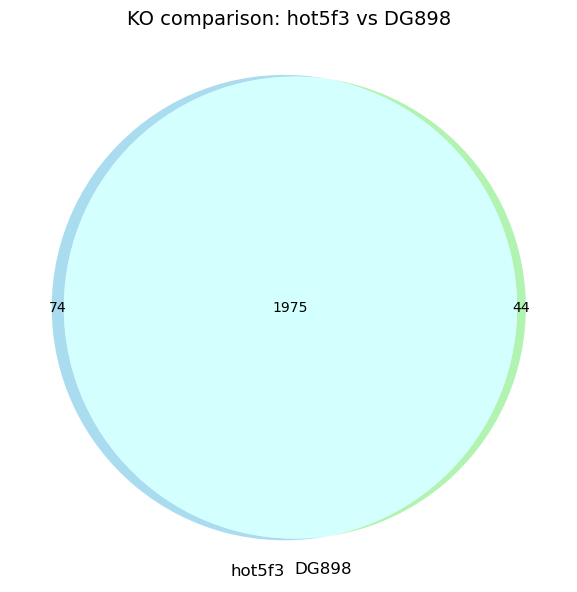

hot5f3 KO amount: 2049
DG898 KO amount: 2019
total KO amout: 1975
KO amount only in hot5f3 : 74
KO amount only in DG898 : 44


In [44]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

# load ko list
ko_hot5f3 = pd.read_csv("hot5f3_KO_list.txt", header=None)[0].dropna().unique()
ko_dg898 = pd.read_csv("DG898_KO_list.txt", header=None)[0].dropna().unique()

set_hot5f3 = set(ko_hot5f3)
set_dg898 = set(ko_dg898)

# plot
plt.figure(figsize=(6,6))
venn2([set_hot5f3, set_dg898],
      set_labels=("hot5f3", "DG898"),
      set_colors=("skyblue", "lightgreen"),
      alpha=0.7)

plt.title("KO comparison: hot5f3 vs DG898", fontsize=14)
plt.tight_layout()
plt.savefig("ko_venn.png", dpi=300)
plt.show()

# Output simple statistics
print(f"hot5f3 KO amount: {len(set_hot5f3)}")
print(f"DG898 KO amount: {len(set_dg898)}")
print(f"total KO amout: {len(set_hot5f3 & set_dg898)}")
print(f"KO amount only in hot5f3 : {len(set_hot5f3 - set_dg898)}")
print(f"KO amount only in DG898 : {len(set_dg898 - set_hot5f3)}")

In [46]:
output_file = "DG898_ko_genelist.txt"

with open("DG898_KO_list.txt") as f_in, open(output_file, "w") as f_out:
    for i, line in enumerate(f_in, start=1):
        ko = line.strip()
        if ko:
            f_out.write(f"gene{i}\t{ko}\n")

print(f"built：{output_file}")

built：DG898_ko_genelist.txt


In [48]:
output_file = "hot5f3_ko_genelist.txt"

with open("hot5f3_ko_list.txt") as f_in, open(output_file, "w") as f_out:
    for i, line in enumerate(f_in, start=1):
        ko = line.strip()
        if ko:
            f_out.write(f"gene{i}\t{ko}\n")

print(f"built：{output_file}")

built：hot5f3_ko_genelist.txt


In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Compare KO sets from two samples (hot5f3 vs DG898) using KEGG REST API.

What this script does (high level):
- Reads two KO lists (one per sample).
- Normalizes KO IDs (uppercase, ensure 'K' prefix).
- Queries KEGG REST API to obtain:
  * KO -> Pathway mappings for the KOs present in either sample.
  * Pathway -> Name mapping for each pathway observed above.
  * Pathway -> All KO mapping (to compute coverage in each pathway).
- Computes per-pathway overlap metrics between the two samples:
  * Hits (how many KOs each sample has in that pathway).
  * Shared/unique KO counts within that pathway.
  * Jaccard similarity (intersection/union) within that pathway.
  * Coverage (fraction of pathway KOs covered by each sample and by the shared set).
- Exports:
  * kegg_shared_pathways.csv: table with pathway-level similarity/coverage metrics.
  * shared.KO.list: KOs shared by both samples.
  * only_hot5f3.KO.list: KOs unique to hot5f3.
  * only_DG898.KO.list: KOs unique to DG898.
  * kegg_mapper_compare.txt: KEGG Mapper/Color input with color coding for shared/unique KOs.

"""

import time
import requests
import pandas as pd
from itertools import islice

# ---------- I/O ----------
# Input text files: one KO ID per line (e.g., K00001). Duplicates and empty lines are ignored.
hot5f3_file = "hot5f3_ko_list.txt"
DG898_file  = "DG898_KO_list.txt"

# ---------- Parameters ----------
# KEGG REST recommends moderate rate limiting. If you see 503/429, increase SLEEP to 0.5–1.0 (seconds),
# or reduce CHUNK size. TIMEOUT controls per-request timeout (seconds), RETRY is the max retry count.
SLEEP = 0.25
RETRY = 3
TIMEOUT = 30
CHUNK = 10  # The KEGG "link" API accepts multiple IDs concatenated with '+' (batch query)

# ---------- Utility functions ----------
def chunked(iterable, n):
    """
    Yield successive chunks of size n from an iterable.
    This helps us call KEGG APIs in batches instead of one ID per request.

    Example:
        list(chunked([1,2,3,4,5], 2)) -> [[1,2],[3,4],[5]]
    """
    it = iter(iterable)
    while True:
        batch = list(islice(it, n))
        if not batch:
            return
        yield batch

def http_get(url, retry=RETRY, sleep=SLEEP, timeout=TIMEOUT):
    """
    HTTP GET with simple retry and incremental backoff.
    - retry: number of attempts
    - sleep: base sleep in seconds; we multiply by (attempt index + 1)
    - timeout: per-request timeout

    Returns:
        Response text if successful (HTTP 200-299).
    Raises:
        RuntimeError if all attempts fail.
    """
    for i in range(retry):
        try:
            r = requests.get(url, timeout=timeout)
            if r.ok:
                return r.text
        except requests.RequestException:
            # Network-related issues (timeouts, connection errors, etc.)
            pass
        # Incremental backoff (sleep, then try again)
        time.sleep(sleep * (i + 1))
    raise RuntimeError(f"Failed GET: {url}")

def normalize_kos(lines):
    """
    Normalize KO IDs read from a file-like iterable:
    - Strip whitespace.
    - Uppercase the string.
    - Ensure the 'K' prefix exists: if the line is numeric (e.g., '00010'), we convert to 'K00010'.
    - Collect into a set to deduplicate.

    Returns:
        A set of normalized KO IDs (e.g., {'K00001', 'K00002', ...}).
    """
    kos = set()
    for line in lines:
        s = line.strip()
        if not s:
            continue
        s = s.upper()
        if not s.startswith("K"):
            # If the user provided pure digits like '00010', add the 'K' prefix.
            if s.isdigit():
                s = "K" + s
        kos.add(s)
    return kos

# ---------- Read KO lists ----------
with open(hot5f3_file) as f:
    hot5f3_kos = normalize_kos(f)

with open(DG898_file) as f:
    DG898_kos = normalize_kos(f)

# Basic KO set relations
shared_kos   = hot5f3_kos & DG898_kos
hot_only_kos = hot5f3_kos - DG898_kos
dg_only_kos  = DG898_kos - hot5f3_kos

print(f"hot5f3: {len(hot5f3_kos)} KO; DG898: {len(DG898_kos)} KO; shared: {len(shared_kos)}")

# ---------- Fetch KO -> Pathway mappings (only for KOs we care about) ----------
def fetch_ko2pathways_for(kos):
    """
    Query KEGG to map KO IDs to pathway IDs.
    Uses the 'link/pathway' endpoint and batches IDs using 'ko:K00001+ko:K00002' syntax.

    Args:
        kos: Iterable of KO IDs (e.g., {'K00001', 'K00002'}).

    Returns:
        Dict[str, set[str]]: ko2pw, mapping from 'Kxxxxx' to a set of 'mapxxxxx' pathway IDs.
        We also ignore 'ko' (organism-specific) pathways and keep 'map' (reference) pathways.
    """
    ko2pw = {}
    if not kos:
        return ko2pw
    # Example endpoint: http://rest.kegg.jp/link/pathway/ko:K00001+ko:K00002
    for batch in chunked(sorted(kos), CHUNK):
        ids = "+".join(f"ko:{k}" for k in batch)
        url = f"http://rest.kegg.jp/link/pathway/{ids}"
        txt = http_get(url)
        for line in txt.strip().splitlines():
            if not line:
                continue
            a, b = line.split("\t")
            k = a.replace("ko:", "")
            p = b.replace("path:", "")
            # Keep only reference pathway IDs (mapxxxxx); ignore species-specific (koxxxxx).
            if k.startswith("K") and p.startswith("map"):
                ko2pw.setdefault(k, set()).add(p)
        # Gentle pacing between batches
        time.sleep(SLEEP)
    return ko2pw

print("Fetching KO->Pathway for shared/hot-only/DG-only KOs ...")
ko2pw_shared   = fetch_ko2pathways_for(shared_kos)
ko2pw_hotonly  = fetch_ko2pathways_for(hot_only_kos)
ko2pw_dgonly   = fetch_ko2pathways_for(dg_only_kos)

# Merge the three partial maps for convenience (union of pathways per KO).
ko2pw_all = {}
for d in (ko2pw_shared, ko2pw_hotonly, ko2pw_dgonly):
    for k, v in d.items():
        ko2pw_all.setdefault(k, set()).update(v)

# ---------- Pathway -> Name mapping ----------
# For every pathway ID we observed in ko2pw_all, query its human-readable name.
all_pw = sorted({pw for s in ko2pw_all.values() for pw in s})
pw2name = {}
for pw in all_pw:
    # Single-pathway query: http://rest.kegg.jp/list/map00010
    txt = http_get(f"http://rest.kegg.jp/list/{pw}")
    # Expected format: "map00010\tGlycolysis / Gluconeogenesis - Reference pathway"
    parts = txt.strip().split("\t")
    if len(parts) >= 2:
        pw2name[pw] = parts[1].strip()
    else:
        pw2name[pw] = ""
    time.sleep(SLEEP)

# ---------- Pathway -> Full KO set (to compute coverage) ----------
def fetch_pathway_kos(pw):
    """
    Fetch the full set of KOs associated with one reference pathway.

    Endpoint:
        http://rest.kegg.jp/link/ko/path:map00010

    Returns:
        A set of KO IDs (e.g., {'K00844', 'K00845', ...}) for the given pathway.
    """
    txt = http_get(f"http://rest.kegg.jp/link/ko/path:{pw}")
    kos = set()
    for line in txt.strip().splitlines():
        # Line format: "path:map00010\tko:K00844"
        if not line:
            continue
        _, ko = line.split("\t")
        kos.add(ko.replace("ko:", ""))
    return kos

print("Fetching KO set for each pathway (to compute coverage) ...")
pw2allkos = {}
for pw in all_pw:
    try:
        pw2allkos[pw] = fetch_pathway_kos(pw)
    except Exception as e:
        # If a request fails, fall back to an empty set so coverage becomes blank in the table.
        pw2allkos[pw] = set()
    time.sleep(SLEEP)

# ---------- Statistics and per-pathway metrics ----------
records = []
for pw in all_pw:
    name = pw2name.get(pw, "")
    pw_kos = pw2allkos.get(pw, set())  # Universe of KO IDs for this pathway (reference map)

    # KOs from each sample that fall into this pathway
    hot_set = (hot5f3_kos & pw_kos)
    dg_set  = (DG898_kos  & pw_kos)

    # Shared/unique sets within this pathway
    shared_set   = hot_set & dg_set          # KOs truly shared AND present in this pathway
    hot_only_set = hot_set - dg_set
    dg_only_set  = dg_set  - hot_set

    # Counts
    n_all    = len(pw_kos) if pw_kos else None  # Size of the pathway KO universe (None if unknown)
    n_hot    = len(hot_set)
    n_dg     = len(dg_set)
    n_shared = len(shared_set)

    # Jaccard similarity within this pathway: |intersection| / |union|
    denom = len(hot_set | dg_set)
    jacc = (len(shared_set) / denom) if denom else 0.0

    # Coverage: fraction of the pathway KO universe covered by each sample/shared set
    cov_hot    = (n_hot / n_all) if n_all else None
    cov_dg     = (n_dg  / n_all) if n_all else None
    cov_shared = (n_shared / n_all) if n_all else None

    # Two notions of "shared" at the pathway level:
    # - both_have_hits: both samples have at least one KO in this pathway (weaker condition)
    # - has_shared_hits: they share at least one identical KO in this pathway (stronger condition)
    both_have_hits   = (n_hot > 0 and n_dg > 0)
    has_shared_hits  = (n_shared > 0)

    records.append({
        "Pathway ID": pw,
        "Pathway Name": name,
        "hot5f3_hits": n_hot,
        "DG898_hits": n_dg,
        "shared_hits": n_shared,
        "hot_only_hits": len(hot_only_set),
        "DG_only_hits": len(dg_only_set),
        "Jaccard_in_pathway": round(jacc, 4),
        "Coverage_hot5f3": round(cov_hot, 4) if cov_hot is not None else "",
        "Coverage_DG898": round(cov_dg, 4) if cov_dg is not None else "",
        "Coverage_shared": round(cov_shared, 4) if cov_shared is not None else "",
        "both_have_hits": "Yes" if both_have_hits else "No",
        "has_shared_hits": "Yes" if has_shared_hits else "No",
    })

df = pd.DataFrame.from_records(records)

# Recommended sort order:
# 1) Pathways where both samples have hits (Yes first),
# 2) Then those with actual shared KOs (Yes first),
# 3) Then higher shared_hits,
# 4) Then higher Jaccard similarity,
# 5) Finally, by Pathway ID ascending (for stable ordering).
df = (df.sort_values(
        by=["both_have_hits", "has_shared_hits", "shared_hits", "Jaccard_in_pathway", "Pathway ID"],
        ascending=[False,        False,           False,          False,                 True]
     ))

# Save the main comparison table (UTF-8 with BOM for easy Excel opening on Windows)
df.to_csv("kegg_shared_pathways.csv", index=False, encoding="utf-8-sig")

# ---------- Output KO lists for KEGG Mapper ----------
# Simple lists of KOs you can directly upload to KEGG Mapper (Search & Color Pathway).
with open("shared.KO.list", "w") as f:
    f.write("\n".join(sorted(shared_kos)))

with open("only_hot5f3.KO.list", "w") as f:
    f.write("\n".join(sorted(hot_only_kos)))

with open("only_DG898.KO.list", "w") as f:
    f.write("\n".join(sorted(dg_only_kos)))

# KEGG Mapper/Color format: "Kxxxxx<TAB>#RRGGBB"
# We assign colors for quick visual comparison:
# - Shared: green
# - hot5f3-only: red
# - DG898-only: blue
with open("kegg_mapper_compare.txt", "w") as f:
    for k in sorted(shared_kos):
        f.write(f"{k}\t green\n")  # green
    for k in sorted(hot_only_kos):
        f.write(f"{k}\t red\n")  # red
    for k in sorted(dg_only_kos):
        f.write(f"{k}\t blue\n")  # blue

print("Generated files:")
print("  shared.KO.list             → Common KO (can be directly uploaded to KEGG Mapper)")
print("  only_hot5f3.KO.list        → hot5f3 exclusive KO")
print("  only_DG898.KO.list         → DG898 exclusive KO")
print("  kegg_mapper_compare.txt    → KEGG Mapper/Color input (common/unique coloring)")
print("  kegg_shared_pathways.csv   → Pathway similarity and coverage table centered on common KOs")

hot5f3: 2049 KO; DG898: 2019 KO; shared: 1975
Fetching KO->Pathway for shared/hot-only/DG-only KOs ...
Fetching KO set for each pathway (to compute coverage) ...
Generated files:
  shared.KO.list             → Common KO (can be directly uploaded to KEGG Mapper)
  only_hot5f3.KO.list        → hot5f3 exclusive KO
  only_DG898.KO.list         → DG898 exclusive KO
  kegg_mapper_compare.txt    → KEGG Mapper/Color input (common/unique coloring)
  kegg_shared_pathways.csv   → Pathway similarity and coverage table centered on common KOs


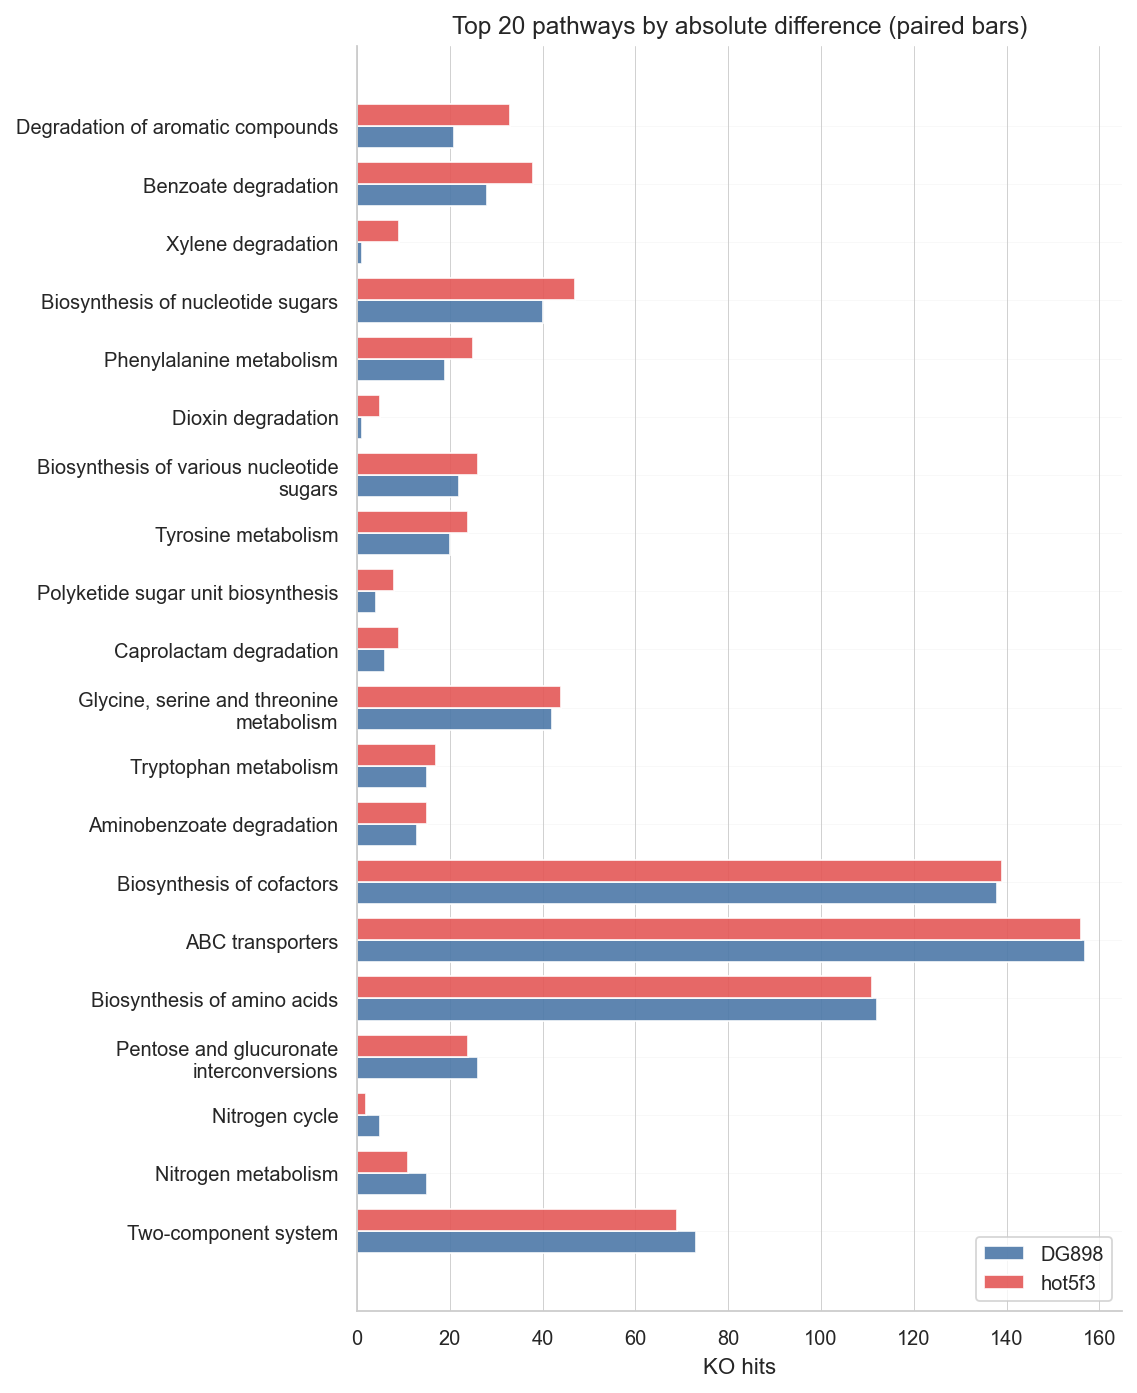

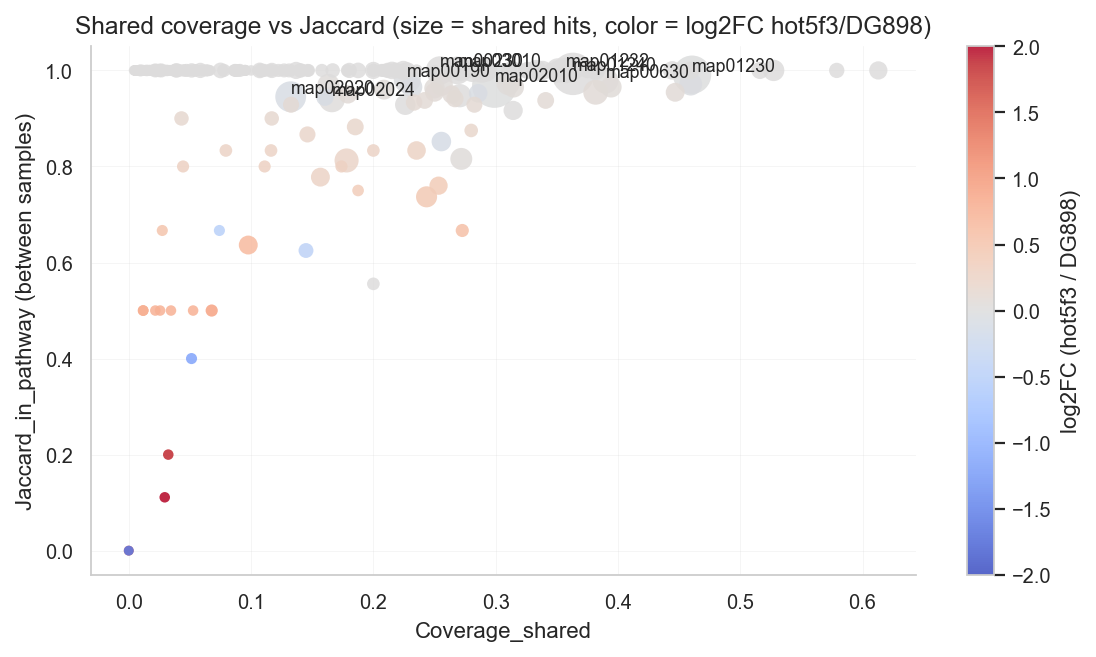

Figures saved to: /Users/huangyu/Desktop/egg_carveme/egg_results/results


In [25]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from textwrap import fill

# Optional: automatic label collision handling
try:
    from adjustText import adjust_text
except Exception:
    adjust_text = None

# -------------------- Style --------------------
sns.set(style="whitegrid", context="paper")
plt.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "axes.linewidth": 0.8,
    "grid.linewidth": 0.4,
})

# -------------------- I/O --------------------
infile = "kegg_shared_pathways.csv"
outdir = Path("results"); outdir.mkdir(exist_ok=True)

# -------------------- Helpers --------------------
def normkey(s: str) -> str:
    # Normalize column name for matching: lowercase and strip non-alphanumerics
    return re.sub(r"[^a-z0-9]+", "", str(s).lower())

def smart_rename(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize your CSV headers to standard names.
    This tolerates small differences like extra spaces or truncated display in Excel.
    """
    raw_cols = {normkey(c): c for c in df.columns}
    target = {
        "pathwayid": "Pathway ID",
        "pathwayname": "Pathway Name",
        "hot5f3hits": "hot5f3_hits",
        "dg898hits": "DG898_hits",
        "sharedhits": "shared_hits",
        "hotonlyhits": "hot_only_hits",
        "dgonlyhits": "DG_only_hits",
        "jaccardinpathway": "Jaccard_in_pathway",
        "coveragehot5f3": "Coverage_hot5f3",
        "coveragedg898": "Coverage_DG898",
        "coverageshared": "Coverage_shared",
        "bothhavehits": "both_have_hits",
        "hassharedhits": "has_shared_hits",
    }
    mapping = {}
    for k_norm, std_name in target.items():
        if k_norm in raw_cols:
            mapping[raw_cols[k_norm]] = std_name
        else:
            # Fallback: prefix match (e.g., "jaccardin_p..." → "Jaccard_in_pathway")
            hit = next((raw_cols[k] for k in raw_cols if k.startswith(k_norm)), None)
            if hit is not None:
                mapping[hit] = std_name
    return df.rename(columns=mapping)

def wrap_lab(s, width=36):
    try:
        return fill(str(s), width=width)
    except Exception:
        return s

def clean_pathway_name(s: str) -> str:
    # Remove trailing " - Reference pathway" or similar suffixes
    s = str(s)
    return re.sub(r"\s+-\s+Reference pathway.*$", "", s).strip()

# -------------------- Load & preprocess --------------------
df0 = pd.read_csv(infile)
df0.columns = df0.columns.str.replace("\ufeff", "", regex=True).str.strip()
df0 = smart_rename(df0)

required = [
    "Pathway ID","Pathway Name","hot5f3_hits","DG898_hits",
    "shared_hits","hot_only_hits","DG_only_hits",
    "Jaccard_in_pathway","Coverage_hot5f3","Coverage_DG898",
    "Coverage_shared","both_have_hits","has_shared_hits"
]
missing = [c for c in required if c not in df0.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Keep only reference maps (mapxxxxx)
df = df0[df0["Pathway ID"].astype(str).str.startswith("map", na=False)].copy()

# Types
num_cols = [
    "hot5f3_hits","DG898_hits","shared_hits","hot_only_hits","DG_only_hits",
    "Jaccard_in_pathway","Coverage_hot5f3","Coverage_DG898","Coverage_shared"
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["Pathway Name"] = df["Pathway Name"].astype(str).map(clean_pathway_name)

# Flags to boolean
for c in ["both_have_hits","has_shared_hits"]:
    df[c] = df[c].astype(str).str.strip().str.lower().map({"yes": True, "no": False})

# Derived metrics
df["delta"] = (df["hot5f3_hits"] - df["DG898_hits"]).astype(float)
df["abs_delta"] = df["delta"].abs()
df["mean"] = df[["hot5f3_hits","DG898_hits"]].mean(axis=1)
df["log2FC"] = np.log2((df["hot5f3_hits"].fillna(0) + 0.5) / (df["DG898_hits"].fillna(0) + 0.5))
df["label"] = np.where(df["Pathway Name"].str.len() > 0, df["Pathway Name"], df["Pathway ID"])

# Exclude mega-pathways (optional but recommended for readability)
MEGA = {"map01100","map01110","map01120","map01200"}
df_core = df[~df["Pathway ID"].isin(MEGA)].copy()
df_mega = df[df["Pathway ID"].isin(MEGA)].copy()

# -------------------- 1) Paired horizontal bars (Top-N by abs_delta) --------------------
N = 20
# Basic quality filter: keep pathways where at least one sample is reasonably present
filt = (df_core["both_have_hits"]) | ((df_core["hot5f3_hits"] > 0) | (df_core["DG898_hits"] > 0))
# Avoid noise like 0 vs 1; tune this threshold as needed
filt &= (df_core[["hot5f3_hits","DG898_hits"]].max(axis=1) >= 2)

sub = (df_core[filt]
       .assign(total=lambda d: d["hot5f3_hits"] + d["DG898_hits"])
       .sort_values(["abs_delta","total"], ascending=[False, False])
       .head(N)
       .sort_values("delta"))

fig, ax = plt.subplots(figsize=(7.2, 0.38*len(sub)+1.2))
y = np.arange(len(sub)); h = 0.38
color_dg  = "#4C78A8"
color_hot = "#E45756"

ax.barh(y - h/2, sub["DG898_hits"], height=h, color=color_dg, alpha=0.9, label="DG898")
ax.barh(y + h/2, sub["hot5f3_hits"], height=h, color=color_hot, alpha=0.9, label="hot5f3")

ax.set_yticks(y)
ax.set_yticklabels([wrap_lab(s) for s in sub["label"]])
ax.set_xlabel("KO hits")
ax.set_title(f"Top {N} pathways by absolute difference (paired bars)")
ax.legend(loc="lower right", frameon=True)
ax.grid(axis="y", linestyle="-", alpha=0.15)
sns.despine(ax=ax, left=False, bottom=False)
plt.tight_layout()
plt.savefig(outdir/"bars_top_diff.png", bbox_inches="tight")
plt.savefig(outdir/"bars_top_diff.pdf", bbox_inches="tight")
plt.show()


# -------------------- (2) Scatter: Coverage_shared vs Jaccard_in_pathway --------------------
d = df_core.copy()
d = d[d["Coverage_shared"].notna() & d["Jaccard_in_pathway"].notna()].copy()

fig, ax = plt.subplots(figsize=(7.2, 4.2))
sc = ax.scatter(
    d["Coverage_shared"], d["Jaccard_in_pathway"],
    s=20 + 2.5*d["shared_hits"].fillna(0),  # size ~ shared hits
    c=d["log2FC"], cmap="coolwarm", vmin=-2, vmax=2,
    alpha=0.85, edgecolor="none"
)
ax.set_xlabel("Coverage_shared")
ax.set_ylabel("Jaccard_in_pathway (between samples)")
ax.set_title("Shared coverage vs Jaccard (size = shared hits, color = log2FC hot5f3/DG898)")
cbar = plt.colorbar(sc, ax=ax, label="log2FC (hot5f3 / DG898)")
ax.grid(True, alpha=0.2)
sns.despine(ax=ax, left=False, bottom=False)

# Optionally label top-K pathways (by shared_hits and abs_delta)
K = 10
hl = d.sort_values(["shared_hits","abs_delta"], ascending=[False, False]).head(K)
texts = []
for _, r in hl.iterrows():
    texts.append(ax.text(r["Coverage_shared"], r["Jaccard_in_pathway"], r["Pathway ID"],
                         fontsize=8, ha="left", va="bottom"))
if adjust_text and texts:
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", color="#777", lw=0.6))

plt.tight_layout()
plt.savefig(outdir/"scatter_jaccard_vs_covshared.png", bbox_inches="tight")
plt.savefig(outdir/"scatter_jaccard_vs_covshared.pdf", bbox_inches="tight")
plt.show()

# -------------------- Export the Top-N subset for traceability --------------------
sub.assign(order=np.arange(1, len(sub)+1)).to_csv(outdir/"topN_by_abs_delta.csv", index=False)
print(f"Figures saved to: {outdir.resolve()}")

In [35]:
file = pd.read_csv("kegg_shared_pathways.csv")

,Pathway ID,Pathway Name,hot5f3_hits,DG898_hits,shared_hits,hot_only_hits,DG_only_hits,Jaccard_in_pathway,Coverage_hot5f3,Coverage_DG898,Coverage_shared,both_have_hits,has_shared_hits
0,map01100,Metabolic pathways,844,819,804,40,15,0.9360,0.1732,0.1681,0.1650,Yes,Yes
1,map01110,Biosynthesis of secondary metabolites,312,308,305,7,3,0.9683,0.1405,0.1387,0.1374,Yes,Yes
2,map01120,Microbial metabolism in diverse environments,281,258,251,30,7,0.8715,0.2035,0.1868,0.1818,Yes,Yes
3,map02010,ABC transporters,156,157,154,2,3,0.9686,0.3029,0.3049,0.2990,Yes,Yes
4,map01240,Biosynthesis of cofactors,139,138,138,1,0,0.9928,0.3658,0.3632,0.3632,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,map05034,Alcoholism,2,1,1,1,0,0.5000,0.0233,0.0116,0.0116,Yes,Yes
292,map00621,Dioxin degradation,5,1,1,4,0,0.2000,0.1613,0.0323,0.0323,Yes,Yes
293,map00622,Xylene degradation,9,1,1,8,0,0.1111,0.2647,0.0294,0.0294,Yes,Yes
294,map00404,Staurosporine biosynthesis,1,0,0,1,0,0.0000,0.0250,0.0000,0.0000,No,No


### Discussion
Overall, the two samples look very similar in core metabolism and transport. Pathways like ABC transporters, Biosynthesis of amino acids, and Biosynthesis of cofactors have Jaccard values close to 1, meaning most KO hits overlap between samples; coverage for these sits around 0.30–0.46, suggesting a shared foundational functional profile. The main differences show up in a few areas: DG898 is slightly stronger in Two-component systems and Nitrogen metabolism/Nitrogen cycle, while hot5f3 is stronger in aromatic/xenobiotic degradation (xylene, dioxin, benzoate, aromatic compounds) and in parts of aromatic amino acid metabolism plus nucleotide-sugar biosynthesis. In the scatter plot, those core pathways cluster in the upper-right (high Jaccard and higher shared coverage), whereas more specialized/edge pathways have lower coverage and less overlap, highlighting sample-specific functions.

I’d interpret this as a niche difference: DG898 seems more tuned for environmental sensing and nitrogen use, whereas hot5f3 leans toward degrading/transforming aromatics/xenobiotics and possibly assembling EPS/capsule via nucleotide-sugar biosynthesis. Just note that some of the xenobiotic pathways are small with low coverage, so they’re more sensitive to sequencing depth and annotation noise. To make the conclusions more robust, consider pathway enrichment with significance testing (hypergeometric + FDR), check KEGG Module completion (MCR), compute abundance-weighted coverage/Jaccard if you have quantitative data, and verify marker enzymes (amo/nir/nor/nos for nitrogen; ring-hydroxylases/dioxygenases for aromatics).

In [12]:
output_file = "only_DG898_genelist_KO_list.txt"

with open("only_DG898.KO.list") as f_in, open(output_file, "w") as f_out:
    for i, line in enumerate(f_in, start=1):
        ko = line.strip()
        if ko:
            f_out.write(f"gene{i}\t{ko}\n")

print(f"write：{output_file}")

write：only_DG898_genelist.KO.list


In [14]:
output_file = "only_hot5f3_genelist_KO_list.txt"

with open("only_hot5f3.KO.list") as f_in, open(output_file, "w") as f_out:
    for i, line in enumerate(f_in, start=1):
        ko = line.strip()
        if ko:
            f_out.write(f"gene{i}\t{ko}\n")

print(f"write：{output_file}")

write：only_hot5f3_genelist.KO.list
